In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from itertools import combinations
import seaborn as sns
import os, sys, warnings
from time import time 
from create_feature import * 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# TO DO:
1. Wrap up one function for feature generation 
2. Wrap up one function for model training 
3. Within the submission API, consider proper concat of cache and new test 
    
    * V1 features are row-based --> don't need cache. 
    * V2 features are based on sec_in_bucket (cross-section feat) --> don't need cache. (Perhaps the gen_v2_features function should be changed to not using groupby() ? )
    * V3 features requires timeseries data -->  the cache is needed.
    * The cache should save the timeseries records of all stocks with sufficient length. 
    * The row after concat should be re-ordered. 
    * After calculate features, only the current seconds_in_bucket should be returned. 
    * Standarization: in the training phase, the standarization is implemented on a multi-day scale. In the cached dataset, only limited timesteps are used in Standarization. 
    * Standarization: during training, perhaps we should perform Standarization on cross-section only. 


In [6]:
df = pd.read_csv("../data/train.csv")
df = df[~df['target'].isnull()] 

print(df.shape)
print(f"Trading days: {df['date_id'].nunique()}")
print(f"Stocks: {df['stock_id'].nunique()}")

# df.head()

(5237892, 17)
Trading days: 481
Stocks: 200


In [11]:
df_final, feature_dicts = gen_features(df[df['date_id']<=30], feature_dicts)

In [13]:
df_final.shape 

(327140, 464)

In [7]:
# estimate running time: 9min
prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
categorical_cols = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag']

feature_cols = prices + sizes

df, v1_features, v1_feature_category = gen_v1_features(df, prices)
feature_cols += v1_features
categorical_cols += v1_feature_category

df, v2_features = gen_v2_features(df, prices+sizes+v1_features)
feature_cols += v2_features

df, v3_features = gen_v3_features(df, prices, sizes, v1_features)
feature_cols += v3_features

df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

df = reduce_mem_usage(df, verbose=1)

print(len(feature_cols))

Memory usage of dataframe is 12278.31 MB
Memory usage after optimization is: 9161.28 MB
Decreased by 25.39%
452


In [ ]:
# check if there is any missing values or infinite values
check_invalid_values = pd.DataFrame(columns=['null', 'inf'])
for col in df.columns:
    try:
        check_invalid_values.loc[col] = [df[col].isnull().sum(), np.isinf(df[col]).sum()]
    except:
        print("Skip column: ", col)
        pass
    
check_invalid_values.T


In [ ]:
# df.to_csv("/home/lishi/projects/Competition/data/train_features.csv", index=False)

In [8]:
import lightgbm as lgb
import joblib, gc
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


In [9]:
def standardize(df, feature_cols):
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df

In [10]:
# set lgb parameters
lgb_params = {
    'learning_rate': 0.009,#0.018,
    'max_depth': 10,#9,
    'n_estimators': 700,#600,
    'num_leaves': 500,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 24
    }

In [11]:
# CV strategy: KFold
# split train and valid set by date_id
# Within each fold, a continuous period of n days is used as validation set
# The start date of validation set is shifted by n day for each fold
# n = total_days / n_fold

k_fold = KFold(n_splits=5, shuffle=False, random_state=None)
kf_split = k_fold.split(df['date_id'].unique())

mae_scores = []
models = []

feature_names = categorical_cols + feature_cols
print(f"Length of feature names: {len(feature_names)}")

for fold, (train_dates, valid_dates) in enumerate(kf_split):
    
    print(f"Fold {fold+1}")
    fold_start = time()
    
    # split train and valid set
    df_train = df[df["date_id"].isin(train_dates)]
    df_valid = df[df["date_id"].isin(valid_dates)]
    
    print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")
    
    df_train_feature = df_train[feature_names]
    df_train_feature = standardize(df_train_feature, feature_cols)
    
    print(f"Train feature: {df_train_feature.shape}, Train target: {df_train['target'].shape}")
    
    df_valid_feature = df_valid[feature_names]
    df_valid_feature = standardize(df_valid_feature, feature_cols)
    
    print(f"Valid feature: {df_valid_feature.shape}, Valid target: {df_valid['target'].shape}")
    
    # train_data = lgb.Dataset(
    #     data=x_train, 
    #     label=y_train, 
    #     feature_name=feature_names,
    #     categorical_feature=categorical_cols
    #     )
    
    # valid_data = lgb.Dataset(
    #     data=x_valid, 
    #     label=y_valid, 
    #     feature_name=feature_names,
    #     categorical_feature=categorical_cols
    #     )
    
    print(f"Data preparation finished. Time elapsed: {time()-fold_start:.2f}s")
    
    print("Start training...")
    training_start = time()
    
    # model = lgb.train(lgb_params, train_data, valid_sets=[train_data, valid_data])
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_train_feature, 
        df_train['target'],
        eval_set=[(df_valid_feature, df_valid['target'])],
        feature_name = feature_names,
        categorical_feature = categorical_cols,
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
            ],
        )
    
    models.append(lgb_model)
    
    model_file = f"../data/lgb_regressor_fold_{fold+1}.pkl" 
    joblib.dump(lgb_model, model_file)
    
    print(f"Fold {fold+1} Trainning finished. Time elapsed: {time()-training_start:.2f}s")
    
    y_pred_valid = lgb_model.predict(df_valid_feature)
    print(y_pred_valid)
    mae = mean_absolute_error(df_valid['target'], y_pred_valid)
    mae_scores.append(mae)

    print(f"Fold {fold+1} MAE: {mae}")
    print(f"Fold {fold+1} Time elapsed: {time()-fold_start:.2f}s")
    
    del df_train, df_valid, df_train_feature, df_valid_feature
    gc.collect()

print(f"Overall MAE: {np.mean(mae_scores)}")
print("Done!")

Length of feature names: 460
Fold 1
Train : (4203153, 464), Valid : (1034739, 464)
Train feature: (4203153, 460), Train target: (4203153,)
Valid feature: (1034739, 460), Valid target: (1034739,)
Data preparation finished. Time elapsed: 41.28s
Start training...
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.376146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112156
[LightGBM] [Info] Number of data points in the train set: 4203153, number of used features: 460
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start t

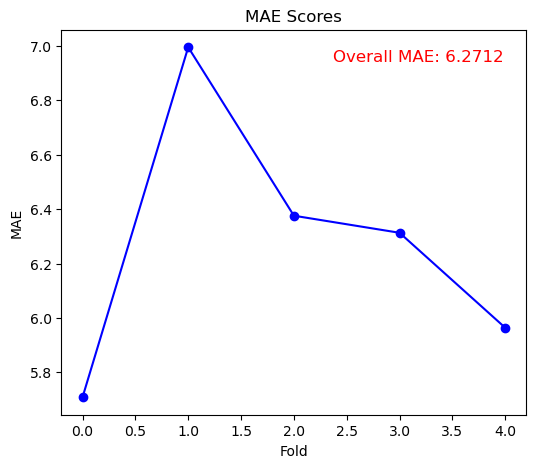

In [12]:
# plot mae scores
plt.figure(figsize=(6, 5))

plt.plot(mae_scores, marker='o', color='blue', label='MAE')
plt.text(0.95, 0.95, f"Overall MAE: {np.mean(mae_scores):.4f}", fontsize=12, ha='right', va='top', color='red', transform=plt.gca().transAxes)
plt.title('MAE Scores')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.show()


In [ ]:
# Plot feature importance using Gain
# fig = plt.figure()
# lgb.plot_importance(model, importance_type="gain", title="LightGBM Feature Importance (Gain)")
# plt.show()
feature_imp = pd.DataFrame({'Value':lgb_model.feature_importances_,'Feature':feature_names})
feature_imp.sort_values(by='Value', ascending=False, inplace=True)

plt.figure(figsize=(8, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.iloc[-60:])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# CV strategy: KFold
# split train and valid set by date_id
# Within each fold, a continuous period of n days is used as validation set
# The start date of validation set is shifted by n day for each fold
# n = total_days / n_fold

# remove the least important features (based on feature importance)
remove_features = feature_imp.iloc[-60:].Feature.tolist()

k_fold = KFold(n_splits=5, shuffle=False, random_state=None)
kf_split = k_fold.split(df['date_id'].unique())

mae_scores = []
models = []

feature_names = [x for x in categorical_cols + feature_cols if x not in remove_features]
feature_cols_less = [x for x in feature_cols if x not in remove_features]
categorical_cols_less = [x for x in categorical_cols if x not in remove_features]

print(f"Length of feature names: {len(feature_names)}")

for fold, (train_dates, valid_dates) in enumerate(kf_split):
    
    print(f"Fold {fold+1}")
    fold_start = time()
    
    # split train and valid set
    df_train = df[df["date_id"].isin(train_dates)]
    df_valid = df[df["date_id"].isin(valid_dates)]
    
    print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")
    
    df_train_feature = df_train[feature_names]
    df_train_feature = standardize(df_train_feature, feature_cols_less)
    
    print(f"Train feature: {x_train.shape}, Train target: {y_train.shape}")
    
    df_valid_feature = df_valid[feature_names]
    df_valid_feature = standardize(df_valid_feature, feature_cols_less)
    
    print(f"Valid feature: {x_valid.shape}, Valid target: {y_valid.shape}")
    
    print(f"Data preparation finished. Time elapsed: {time()-fold_start:.2f}s")
    
    print("Start training...")
    training_start = time()
    
    # model = lgb.train(lgb_params, train_data, valid_sets=[train_data, valid_data])
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_train_feature, 
        df_train['target'],
        eval_set=[(df_valid_feature, df_valid['target'])],
        feature_name = feature_names,
        categorical_feature = categorical_cols_less,
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
            ],
        )
    
    models.append(lgb_model)
    
    model_file = f"../data/lgb_regressor_fold_{fold+1}_feat_400.pkl" 
    joblib.dump(lgb_model, model_file)
    
    print(f"Fold {fold+1} Trainning finished. Time elapsed: {time()-training_start:.2f}s")
    
    y_pred_valid = lgb_model.predict(df_valid_feature)
    mae = mean_absolute_error(df_valid['target'], y_pred_valid)
    mae_scores.append(mae)

    print(f"Fold {fold+1} MAE: {mae}")
    print(f"Fold {fold+1} Time elapsed: {time()-fold_start:.2f}s")
    
    del df_train, df_valid, df_train_feature, df_valid_feature
    gc.collect()

print(f"Overall MAE: {np.mean(mae_scores)}")
print("Done!")

In [ ]:
# plot mae scores
plt.figure(figsize=(6, 5))

plt.plot(mae_scores, marker='o', color='blue', label='MAE')
plt.text(0.95, 0.95, f"Overall MAE: {np.mean(mae_scores):.4f}", fontsize=12, ha='right', va='top', color='red', transform=plt.gca().transAxes)
plt.title('MAE Scores')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.show()

In [ ]:
feature_imp = pd.DataFrame({'Value':lgb_model.feature_importances_,'Feature':feature_names})
feature_imp.sort_values(by='Value', ascending=False, inplace=True)

plt.figure(figsize=(8, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.iloc[2:60])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
models 

In [ ]:
import sys 

# add path of optiver2023 package to pythonpath 
sys.path.append(os.path.abspath('../data'))

In [ ]:
import optiver2023 

In [ ]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0 

y_min, y_max = -64, 64
qps, predictions = [], []
cache = pd.DataFrame()

prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
categorical_cols = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag']

feature_cols = prices + sizes

for (test, revealed_targets, sample_prediction) in iter_test:
    now_time = time()
    
    test_len = len(test)
    
    test, v1_features, v1_feature_category = gen_v1_features(test, prices)
    feature_cols += v1_features
    categorical_cols += v1_feature_category

    test, v2_features = gen_v2_features(test, prices+sizes+v1_features)
    feature_cols += v2_features
    
    cache = pd.concat([cache, test], ignore_index=True, axis=0)
    
    if counter > 0:
        cache = cache.sort_values(['date_id', 'stock_id', 'seconds_in_bucket']).reset_index(drop=True)
        dates_unique = cache['date_id'].unique()
        cache = cache[cache['date_id'] == dates_unique[-1]].reset_index(drop=True)
        print(counter, cache.shape)

    cache, v3_features = gen_v3_features(cache, prices, sizes, v1_features)
    feature_cols += v3_features 

    cache.fillna(0, inplace=True)
    cache.replace([np.inf, -np.inf], 0, inplace=True)

    cache = reduce_mem_usage(cache, verbose=1)
    
    df_test = cache[-test_len:]
    
    print(f"df_test shape: {df_test.shape}")
    print(f"Feature preprocess done! Time elapsed: {time()-now_time:.2f}s")
    
    # lgb_predictions = np.zeros(len(cache))
    # for model in models:
    #     lgb_predictions +=  model.predict(df_test[feature_cols])

    print(len(feature_cols))



In [ ]:
# A simple validation split: keep the last 45 days for validation

# split_day = 435
# df_train = df[df["date_id"] <= split_day]
# df_valid = df[df["date_id"] > split_day]
# print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")

# df_train_feature = df_train[categorical_cols + feature_cols]
# df_train_target = df_train["target"]

# df_valid_feature = df_valid[categorical_cols + feature_cols]
# df_valid_target = df_valid["target"]

# print(f"Train feature: {df_train_feature.shape}, Train target: {df_train_target.shape}")
# print(f"Valid feature: {df_valid_feature.shape}, Valid target: {df_valid_target.shape}")

In [ ]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
df_train_feature = standardize(df_train_feature, feature_cols)
df_valid_feature = standardize(df_valid_feature, feature_cols)

In [ ]:
# define a Dataset class
class MyDataset(Dataset):
    def __init__(self, features, target):
        self.y = target
        self.X = features
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]
    
    
# define a neural network model of 2 layers
# first layer is a non-linear layer with m neurons
# second layer is a linear layer with n neuron

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_relu_stack(x)
        return output
    
# define a function to train the model
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        local_data, local_target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(local_data.float())
        loss = criterion(output, local_target.float())
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

# define a function for validation
def validation(model, val_loader, criterion):
    model.eval()
    validation_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in val_loader:
            local_data, local_target = data.to(device), target.to(device)
            output = model(local_data.float())
            validation_loss += criterion(output, local_target.float()).item()
            y_true.extend(target.tolist())
            y_pred.extend(output.tolist())
            
    validation_loss /= len(val_loader.dataset)
    print(f"\nValidation set: Average loss: {validation_loss:.6f}")
    print(f"\nValidation set: Mean Average Error: {mean_absolute_error(y_true, y_pred):.6f}\n")

# define a function to predict the target
def predict(model, pred_loader):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for data, target in pred_loader:
            output = model(data.float())
            y_pred.extend(output.tolist())
            
    return y_pred

In [ ]:
train_dataset = MyDataset(torch.from_numpy(df_train_feature.values), torch.from_numpy(df_train_target.values))
valid_dataset = MyDataset(torch.from_numpy(df_valid_feature.values), torch.from_numpy(df_valid_target.values))

# print number of data points and number of features
print(f"Number of data points: {train_dataset.X.shape[0]}")
print(f"Number of features: {train_dataset.X.shape[1]}")


In [ ]:
model = NeuralNetwork(460, 128, 1).to(device)

# train the model with train_dataset
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=True)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(1, 3):
    train(model, train_loader, optimizer, criterion, epoch)
    validation(model, val_loader, criterion)